In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
import numpy as np
from pyscf import dft, scf, gto, cc
from pyscfad import dft as dft_ad
from pyscfad import gto as gto_ad
from functools import partial
import pylibxc
import pyscfad.dft as dftad
from jax import custom_jvp
jax.config.update("jax_enable_x64", True) #Enables 64 bit precision


from xcquinox import net
from xcquinox.loss import compute_loss_mae
from xcquinox.train import Pretrainer
from xcquinox.utils import gen_grid_s, PBE_Fx, PBE_Fc, calculate_stats, lda_x, pw92c_unpolarized

/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# Compute inputs

In [2]:
#training and validation values
inds, vals, tflats, vflats = gen_grid_s(npts = 1e5)
train_inds, val_inds = inds
rv, grv, sv = vals
trf, tgrf, tsf = tflats
vrf, vgrf, vsf = vflats
#training and validation values for SIGMA
sinds, svals, stflats, svflats = gen_grid_s(npts = 1e5, sigma=True)
strain_inds, sval_inds = sinds
srv, sgrv, ssv = svals
strf, stgrf, stsf = stflats
svrf, svgrf, svsf = svflats

shapes- r/gr/s: (315,)/(315,)/(315,)
shapes- r/gr/s: (315,)/(315,)/(315,)


In [3]:
ref_fx = PBE_Fx(trf, tgrf)
ref_fc = PBE_Fc(trf, tgrf)

siginputs = jnp.stack([strf, stgrf], axis=1)


In [4]:
#sigma-based networks
spbe_fx = net.GGA_FxNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
spbe_fc = net.GGA_FcNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)

In [5]:
#create optimizers
soptimizer_fx = optax.chain(
    optax.adam(learning_rate=1e-3)
)
soptimizer_fc = optax.chain(
    optax.adam(learning_rate=1e-3)
)
spt_pbe_fx = Pretrainer(model = spbe_fx, optim = soptimizer_fx, inputs = siginputs, ref = ref_fx, loss = compute_loss_mae, steps = 2500)
spt_pbe_fc = Pretrainer(model = spbe_fc, optim = soptimizer_fc, inputs = siginputs, ref = ref_fc, loss = compute_loss_mae, steps = 2500)



In [6]:
# snmx, snlx = spt_pbe_fx()
# snmc, snlc = spt_pbe_fc()

In [7]:
# net.save_xcquinox_model(snmx, path='pretrained_test', loss=snlx)
# net.save_xcquinox_model(snmc, path='pretrained_test', loss=snlc)

In [8]:
snmx = net.load_xcquinox_model('pretrained_test/GGA_FxNet_sigma_d3_n16_s92017')
snmc = net.load_xcquinox_model('pretrained_test/GGA_FcNet_sigma_d3_n16_s92017')
snlx = np.loadtxt('pretrained_test/GGA_FxNet_sigma_d3_n16_s92017_loss.txt')
snlc = np.loadtxt('pretrained_test/GGA_FcNet_sigma_d3_n16_s92017_loss.txt')

Loaded pretrained_test/GGA_FxNet_sigma_d3_n16_s92017.eqx
Loaded pretrained_test/GGA_FcNet_sigma_d3_n16_s92017.eqx


In [9]:
def custom_pbe_Fx(rho, sigma, XNET = None):
    #this will be a call to the Fx neural network we want
    # print('DEBUG custom_pbe_Fx, rho/sigma shapes: ', rho.shape, sigma.shape)
    # print('DEBUG custom_pbe_Fx: rho: ', rho)
    # print('DEBUG custom_pbe_Fx: sigma: ', sigma)

    Fx = XNET([rho, sigma])
    return Fx

def custom_pbe_Fc(rho, sigma, CNET = None): #Assumes zeta = 0
    #this will be a call to the Fc neural network we want
    Fc = CNET([rho, sigma])
    return Fc

def custom_pbe_e(rho, sigma, XNET = None, CNET = None):
    Fx = custom_pbe_Fx(rho, sigma, XNET = XNET)
    Fc = custom_pbe_Fc(rho, sigma, CNET = CNET)

    exc = lda_x(rho)*Fx + pw92c_unpolarized(rho)*Fc

    return exc

def custom_pbe_epsilon(rho, sigma, XNET = None, CNET = None):

    return rho*custom_pbe_e(rho, sigma, XNET = XNET, CNET = CNET)

def derivable_custom_pbe_e(rhosigma, XNET = None, CNET = None):
    rho, sigma = rhosigma
    # print('DEBUG derivable_custom_pbe_e: rhosigma len/shapes: ', len(rhosigma), rhosigma)
    # print('DEBUG derivable_custom_pbe_e: rho/sigma shapes: ', rho.shape, sigma.shape)
    # print('DEBUG derivable_custom_pbe_e: rho: ', rho)
    # print('DEBUG derivable_custom_pbe_e: sigma: ', sigma)
    return custom_pbe_e(rho, sigma, XNET = XNET, CNET = CNET)

def derivable_custom_pbe_epsilon(rhosigma, XNET = None, CNET = None):
    rho = rhosigma[0]
    sigma = rhosigma[1]
    result = custom_pbe_epsilon(rho, sigma, XNET = XNET, CNET = CNET)
    return result[0]
    
def eval_xc_gga_j(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None,
                 XNET = None, CNET = None):
    #we only expect there to be a rho0 array, but I unpack it as (rho, deriv) here to be in line with the
    #pyscf example -- the size of the 'rho' array depends on the xc type (LDA, GGA, etc.)
    #so since LDA calculation, check for size first.
    rho0, dx, dy, dz = rho[:4]
    rho0 = jnp.array(rho0)
    sigma = jnp.array(dx**2+dy**2+dz**2)
    # print('DEBUG eval_xc_gga_j: rho0/sigma shapes: ', rho0.shape, sigma.shape)
    rhosig = (rho0, sigma)
    #calculate the "custom" energy with rho -- THIS IS e
    #cast back to np.array since that's what pyscf works with
    #pass as tuple -- (rho, sigma)
    derivable_net_e = partial(derivable_custom_pbe_e, XNET = XNET, CNET = CNET)
    derivable_net_epsilon = partial(derivable_custom_pbe_epsilon, XNET = XNET, CNET = CNET)
    exc = np.array(jax.vmap(derivable_net_e)( rhosig ) )
    
    #first order derivatives w.r.t. rho and sigma
    vrho_f = eqx.filter_grad(derivable_net_epsilon)
    vrhosigma = np.array(jax.vmap(vrho_f)( rhosig ))
    # print('vrhosigma shape:', vrhosigma.shape)
    vxc = (vrhosigma[0], vrhosigma[1], None, None)

    # v2_f = eqx.filter_hessian(derivable_custom_pbe_epsilon)
    v2_f = jax.hessian(derivable_net_epsilon)
    # v2_f = jax.hessian(custom_pbe_epsilon, argnums=[0, 1])
    v2 = np.array(jax.vmap(v2_f)( rhosig ))
    # print('v2 shape', v2.shape)
    v2rho2 = v2[0][0]
    v2rhosigma = v2[0][1]
    v2sigma2 = v2[1][1]
    v2lapl2 = None
    vtau2 = None
    v2rholapl = None
    v2rhotau = None
    v2lapltau = None
    v2sigmalapl = None
    v2sigmatau = None
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    #3rd order
    kxc = None
    
    return exc, vxc, fxc, kxc

def eval_xc_gga_j2(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None,
                 xcmodel = None):
    #we only expect there to be a rho0 array, but I unpack it as (rho, deriv) here to be in line with the
    #pyscf example -- the size of the 'rho' array depends on the xc type (LDA, GGA, etc.)
    #so since LDA calculation, check for size first.
    try:
        rho0, dx, dy, dz = rho[:4]
        sigma = jnp.array(dx**2+dy**2+dz**2)
    except:
        rho0, drho = rho[:4]
        sigma = jnp.array(drho**2)
    rho0 = jnp.array(rho0)
    # sigma = jnp.array(dx**2+dy**2+dz**2)
    # print('DEBUG eval_xc_gga_j: rho0/sigma shapes: ', rho0.shape, sigma.shape)
    # rhosig = (rho0, sigma)
    rhosig = jnp.stack([rho0, sigma], axis=1)
    # print(rhosig.shape)
    #calculate the "custom" energy with rho -- THIS IS e
    #cast back to np.array since that's what pyscf works with
    #pass as tuple -- (rho, sigma)
    exc = jax.vmap(xcmodel)(rhosig)
    exc = jnp.array(exc)/rho0
    # exc = jnp.array(jax.vmap(xcmodel)( rhosig ) )/rho0
    # print('exc shape = {}'.format(exc.shape))
    #first order derivatives w.r.t. rho and sigma
    vrho_f = eqx.filter_grad(xcmodel)
    vrhosigma = jnp.array(jax.vmap(vrho_f)( rhosig ))
    # print('vrhosigma shape:', vrhosigma.shape)
    vxc = (vrhosigma[:, 0], vrhosigma[:, 1], None, None)

    # v2_f = eqx.filter_hessian(derivable_custom_pbe_epsilon)
    v2_f = jax.hessian(xcmodel)
    # v2_f = jax.hessian(custom_pbe_epsilon, argnums=[0, 1])
    v2 = jnp.array(jax.vmap(v2_f)( rhosig ))
    # print('v2 shape', v2.shape)
    v2rho2 = v2[:, 0, 0]
    v2rhosigma = v2[:, 0, 1]
    v2sigma2 = v2[:, 1, 1]
    v2lapl2 = None
    vtau2 = None
    v2rholapl = None
    v2rhotau = None
    v2lapltau = None
    v2sigmalapl = None
    v2sigmatau = None
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    #3rd order
    kxc = None
    
    return exc, vxc, fxc, kxc

In [10]:
mol = gto_ad.Mole(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol.verbose = 0
mol.max_memory = 32000
mf = dft_ad.RKS(mol)
mf.grids.level = 1
mf.xc = 'pbe'
mf.kernel()
start_hf = scf.RHF(mol)
start_hf.kernel()
cc_h2o = cc.CCSD(start_hf)
cc_h2o.kernel()

Initialize <pyscfad.gto.mole.Mole object at 0x74df80197790> in RKS-KohnShamDFT object of <class 'pyscfad.dft.rks.RKS'>
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/ICN2/snavarro/.local/lib/python

(-0.21334324588829462,
 array([[ 6.32837811e-05,  2.92312017e-17,  4.03706978e-18,
         -4.60673625e-05,  7.40241332e-05, -1.83833314e-18,
          1.41647244e-17,  9.19758904e-05, -7.18291004e-19,
         -5.03548522e-20, -1.86187389e-04, -1.00530221e-17,
          1.08712274e-17,  8.62713654e-05,  7.24340597e-20,
         -1.77459330e-19, -5.87393933e-06,  3.21678470e-05,
         -1.30793054e-17],
        [-3.91228510e-03,  8.75377978e-17,  1.66174026e-16,
          3.57507648e-05, -4.24256897e-03, -4.60162076e-18,
         -4.01905600e-16, -3.68473231e-04,  8.61751861e-18,
          5.04198624e-18, -1.47203123e-03,  3.62205259e-16,
         -2.95594498e-16,  2.67542416e-03, -4.73998277e-18,
          1.27271413e-17, -1.07208920e-04,  9.07975760e-04,
         -1.99499869e-17],
        [ 6.94069490e-16,  5.94474731e-03, -1.84260436e-03,
          4.44253067e-16, -1.68253664e-16, -1.12277113e-17,
         -4.54656237e-03, -1.40315049e-16,  5.84501605e-17,
          5.81796221e-1

In [11]:
#generate CCSD density using DFT coordinates and CCSD density matrix.
ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=2)
CCSD_COORDS = np.array(mf.grids.coords)
ccsd_dm = cc_h2o.make_rdm1()
target_dm = jnp.array(ccsd_dm)
TARGET_ENERGY = cc_h2o.e_tot
print('DEBUG target_dm shape:', target_dm.shape)

DEBUG target_dm shape: (24, 24)


In [12]:
eigv, _= np.linalg.eig(target_dm)
print('DEBUG eigv:', eigv)
print(np.sum(eigv))


DEBUG eigv: [1.99991681e+00 1.98459067e+00 1.96696591e+00 1.97305493e+00
 1.96442851e+00 2.46157074e-02 2.65935957e-02 1.14791795e-02
 1.69599910e-02 5.60893825e-03 4.50260063e-03 5.87779259e-03
 5.10134296e-03 4.39218690e-03 5.67200542e-05 1.13572389e-03
 3.96208119e-05 1.15487305e-03 5.96356575e-04 4.89070427e-04
 7.33387512e-04 6.66228613e-04 4.97915524e-04 5.41950004e-04]
10.0


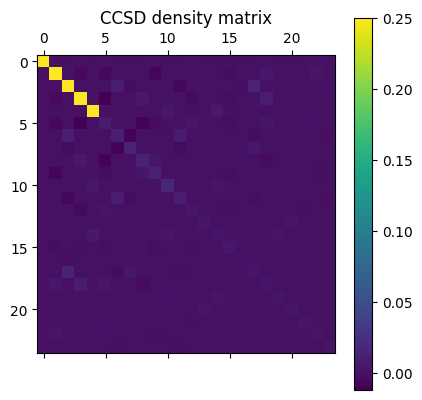

In [13]:
plt.matshow(target_dm, vmax=0.25)
plt.colorbar()
plt.title('CCSD density matrix')
plt.show()

In [ ]:
@eqx.filter_value_and_grad
def opt_loss_TE_dm(model, mols, refs):
    WEIGHT_E = 1.0
    WEIGHT_RHO = 20.0
    total_loss = 0
    for idx, mol in enumerate(mols):
        mf = dft_ad.RKS(mol)
        custom_eval_xc = partial(eval_xc_gga_j2, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'GGA')
        mf.kernel()
        ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=1)
        dm = mf.make_rdm1()
        loss_E = abs(mf.e_tot - refs[idx][0])
        loss_dm = abs(dm - refs[idx][1]).sum()/mol.nelectron
        total_loss += WEIGHT_E * loss_E + WEIGHT_RHO * loss_dm
    total_loss /= len(mols)
    return total_loss[..., jnp.newaxis][0]

In [15]:
class RXCModel(eqx.Module):
    xnet: eqx.Module
    cnet: eqx.Module

    def __init__(self, xnet, cnet):
        self.xnet = xnet
        self.cnet = cnet
        
    def __call__(self, inputs):
        #this generate epsilon, not exc -- divide end result by rho when needed
        rho = inputs[0]
        sigma = inputs[1]
        # print('RXCModel call - inputs {}'.format(inputs))
        return rho*(lda_x(rho)*jax.vmap(self.xnet)(inputs[..., jnp.newaxis]) + pw92c_unpolarized(rho)*jax.vmap(self.cnet)(inputs[..., jnp.newaxis])).flatten()[0]
        # return rho*(lda_x(rho)*self.xnet(inputs) + pw92c_unpolarized(rho)*self.cnet(inputs)).flatten()[0]

In [16]:
from typing import Callable

class Optimizer(eqx.Module):
    model: eqx.Module
    optim: optax.GradientTransformation
    steps: int
    print_every: int
    opt_state: tuple
    mols: list
    refs: jnp.array
    loss: Callable

    def __init__(self, model, optim, mols, refs, loss, steps=1000, print_every=100):
        '''
        The Pretrainer object aids in the initial pre-training of enhancement factor networks to have a more physical starting point for further network optimization. This class is meant to pre-train a randomly initialized network to fit the values of a specific XC functional's enhancement factor (either X or C, in principle it could also be a combined XC enhancement facator)

        :param model: The enhancement factor network to be pre-trained
        :type model: :xcquinox.net: class
        :param optim: The optimizer than will control the weight updates given a loss and gradient
        :type optim: optax.GradientTransformation
        :param inputs: The inputs the network itself is expecting in its forward pass function
        :type inputs: jnp.array
        :param ref: The reference values the network is expected to reproduce
        :type ref: jnp.array
        :param loss: A function from :xcquinox.loss: that is decorated with @eqx.filter_value_and_grad
        :type loss: Callable
        :param steps: Number of epochs to train over, defaults to 1000
        :type steps: int, optional
        :param print_every: How often to print loss statistic, defaults to 100
        :type print_every: int, optional
        '''
        super().__init__()
        self.model = model
        self.optim = optim
        self.mols = mols
        self.refs = refs
        self.steps = steps
        self.print_every = print_every
        self.opt_state = self.optim.init(eqx.filter(self.model, eqx.is_array))
        self.loss = loss

    def __call__(self):
        '''
        The training loop itself. Here, a loop over the specifed epochs takes place to train the network to fit reference values.

        :return: The trained model and an array of the losses during training.
        :rtype: (:xcquinox.net: class, array)
        '''
        losses = []
        for epoch in range(self.steps):
            if epoch == 0:
                this_model = self.model
                this_opt_state = self.opt_state
            loss, this_model, this_opt_state = self.make_step(this_model, self.mols, self.refs, this_opt_state)
            lossi = loss.item()
            losses.append(lossi)
            if epoch % self.print_every == 0:
                print(f'Epoch {epoch}: Loss = {lossi}')

        return this_model, losses

    # @eqx.filter_jit
    def make_step(self, model, inputs, ref, opt_state):
        '''
        The function that does each epoch's network update. It generates a loss and gradient using the specific :xcquinox.loss: function (that must be decorated with @eqx.filter_value_and_grad and only explicitly returns the loss value inside the function proper) given the specified inputs and reference values and initial optimization state.

        :param model: The enhancement factor network to be pre-trained
        :type model: :xcquinox.net: class
        :param inputs: The inputs the network itself is expecting in its forward pass function
        :type inputs: jnp.array
        :param ref: The reference values the network is expected to reproduce
        :type ref: jnp.array
        :param opt_state: The INITIAL optimization state to work against, typically generated via :self.optim.init(eqx.filter(self.model, eqx.is_array)):
        :type opt_state: The type of the above
        :return: The loss value for this step, the updated model after that loss is calculated, and the new optimization state for this step to use next time
        :rtype: tuple
        '''
        loss, grad = self.loss(model, self.mols, self.refs)
        updates, opt_state = self.optim.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state


In [17]:
test_model = RXCModel(xnet=snmx, cnet=snmc)

In [18]:
mol_ad = gto_ad.Mole(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol_ad.max_memory = 32000
mol_ad.build()
mol_ad.verbose = 0
OPT_INIT_LR = 1e-2
OPT_END_LR = 1e-5
OPTSTEPS = 100
OPTDECAYBEGIN = 30
# OPTDECAYRATE = 0.95
scheduler = optax.linear_schedule(
    init_value = OPT_INIT_LR,
    transition_steps = OPTSTEPS-OPTDECAYBEGIN,
    transition_begin = OPTDECAYBEGIN,
    end_value = OPT_END_LR,
)
opt_opt = optax.adam(learning_rate=scheduler)
opt_snmxc = Optimizer(model=test_model, optim=opt_opt, mols = [mol_ad], refs = [[TARGET_ENERGY, target_dm]], loss=opt_loss_TE_dm, print_every=1, steps=OPTSTEPS)

In [19]:
import warnings
warnings.filterwarnings("ignore")
#a lot of "derivative wrt the leaves not taken" printouts from pyscfad -- suppress that so we can actually see the losses easily

In [20]:
osnmxc, osnmxcl = opt_snmxc()

Epoch 0: Loss = 422.7245953458625
Epoch 1: Loss = 424.1235895186017
Epoch 2: Loss = 423.9586142439417
Epoch 3: Loss = 423.105254139923
Epoch 4: Loss = 421.75045399476386
Epoch 5: Loss = 420.0127045516446
Epoch 6: Loss = 419.61073424452087
Epoch 7: Loss = 419.9625312020361
Epoch 8: Loss = 420.7693980082917
Epoch 9: Loss = 421.0620637572147
Epoch 10: Loss = 420.97547111393163
Epoch 11: Loss = 420.577716639422
Epoch 12: Loss = 419.9023159188803
Epoch 13: Loss = 419.7414314532659
Epoch 14: Loss = 419.9992952926961
Epoch 15: Loss = 420.5872064855252
Epoch 16: Loss = 420.82657376775904
Epoch 17: Loss = 420.7750449459896
Epoch 18: Loss = 420.4655546090967
Epoch 19: Loss = 419.91525692080404
Epoch 20: Loss = 419.7899503667869
Epoch 21: Loss = 420.03320617988066
Epoch 22: Loss = 419.98697373591506
Epoch 23: Loss = 419.6980584965505
Epoch 24: Loss = 419.78751113233756
Epoch 25: Loss = 420.2430233098419
Epoch 26: Loss = 420.3931359508904
Epoch 27: Loss = 420.26998265587645
Epoch 28: Loss = 419.92

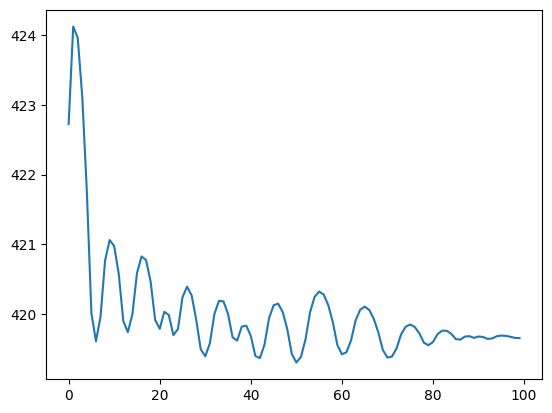

In [21]:
plt.plot(osnmxcl)